# Random Forest
Total dataset size: 134 samples <br>
Training set: 134 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- NDVI
- DEM
- LTA soil moisture - 10 cm (m3 m-3) 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# Prepare all BGS points as training points

# read file (data + coordinates)
file = pd.read_csv('poc_ext.csv')
# OMIT ZERO RECHARGE SAMPLES - comment if zero-recharge sites should be included
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa']< 800]
# drop unimportant columns
data = file.drop(columns=['ID', 'Lat', 'Long', 'Aquifer_group', 'Soil_group', 'Landcover', 'Landcover_ext','LTA_GPCC_mmpa', 'LTA_CHIRPS_mmpa', 'SM10_kgm2', 'LTA_WD_days', 'DEM'])
# Labels are the values we want to predict
labels = np.log10(data['Recharge_mmpa'])
#labels = data['Recharge_mmpa']
data = data.drop('Recharge_mmpa', axis = 1)
# Add for reference
data['ID'] = file['ID']
# Convert to numpy array

# Saving feature names for later use
feature_list = list(data.columns)
features = np.array(data)

data

,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
0,1234.743356,1265.000000,0.977426,0.548899,0.317942,1
1,555.876675,1386.030028,0.403442,0.417538,0.210401,2
2,1376.716688,1337.440024,1.029575,0.687945,0.312940,3
3,518.196676,1590.610029,0.326188,0.268559,0.229384,4
4,1344.580024,1298.693353,1.038857,0.593882,0.330358,5
...,...,...,...,...,...,...
129,655.280013,1356.070025,0.486649,0.403724,0.323871,130
130,816.720013,1266.233355,0.648767,0.479056,0.227937,131
131,510.140009,1922.536704,0.265403,0.327490,0.194245,132
132,1215.073356,1149.026683,1.058098,0.447078,0.279276,133


In [2]:
file

,Recharge_mmpa,LTA_CHIRPS_mmpa,LTA_GPCC_mmpa,LTA_P_mmpa,LTA_WD_days,LTA_PET_mm,Aridity,NDVI,Aquifer_group,Soil_group,Landcover_ext,Landcover,DEM,SM10_m3m3,SM10_kgm2,Lat,Long,ID
0,253.0,1215.759255,1103.60340,1234.743356,106.025664,1265.000000,0.977426,0.548899,Basement,LX,130,shrubland,360,0.317942,23.815275,8.49,4.48,1
1,22.0,475.869821,555.43835,555.876675,67.369998,1386.030028,0.403442,0.417538,Basement,AC,30,grassland,1039,0.210401,17.259396,-20.27,30.09,2
2,245.0,1267.350207,1341.60230,1376.716688,192.223329,1337.440024,1.029575,0.687945,Basement,NT,30,forest,1125,0.312940,26.114550,0.46,32.96,3
3,185.0,482.137867,608.88070,518.196676,59.429665,1590.610029,0.326188,0.268559,Sedimentary,LP,200,sparse,1657,0.229384,19.132140,13.54,39.82,4
4,120.0,1310.878963,1120.90340,1344.580024,139.171331,1298.693353,1.038857,0.593882,Sedimentary,NT,30,cropland,26,0.330358,25.831575,6.50,2.30,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,100.0,611.063066,669.56696,655.280013,85.363665,1356.070025,0.486649,0.403724,Sedimentary,LP,30,shrubland,1376,0.323871,22.159473,-26.00,27.70,130
130,80.0,787.538745,753.93494,816.720013,80.897665,1266.233355,0.648767,0.479056,Basement,CM,130,shrubland,1382,0.227937,19.953318,-17.71,30.55,131
131,8.0,482.529637,467.50770,510.140009,68.636998,1922.536704,0.265403,0.327490,Unconsolidated,GL,14,cropland,28,0.194245,11.226820,14.72,-17.00,132
132,160.0,1010.916120,1053.96100,1215.073356,99.186665,1149.026683,1.058098,0.447078,Sedimentary,LP,20,cropland,2482,0.279276,29.116320,9.40,38.64,133


In [3]:
correlation_matrix = data.corr()
correlation_matrix

,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
LTA_P_mmpa,1.000000,-0.534214,0.973336,0.843510,0.932252,-0.050985
LTA_PET_mm,-0.534214,1.000000,-0.625877,-0.696296,-0.580156,0.009623
Aridity,0.973336,-0.625877,1.000000,0.840664,0.926042,-0.045108
NDVI,0.843510,-0.696296,0.840664,1.000000,0.812939,0.016159
SM10_m3m3,0.932252,-0.580156,0.926042,0.812939,1.000000,-0.020052
ID,-0.050985,0.009623,-0.045108,0.016159,-0.020052,1.000000


# Run RF for the whole domain

In [2]:
# get all coordinates of the smallest raster - workaround as rasters have slightly different shapes
coords, T0, out_shape = getAllCoordinates('Recharge_files/Africa_bgs_LTA_AnnPrecip.tif')
coords_np = np.array([*coords])

In [3]:
# read rasters
pet_src = rasterio.open('Recharge_files/Africa_bgs_LTA_AnnPET.tif')
p_src = rasterio.open('Recharge_files/Africa_bgs_LTA_AnnPrecip.tif')
ndvi_src = rasterio.open('Recharge_files/Africa_NDVI.tif')
ai_src = rasterio.open('Recharge_files/Africa_bgs_aridity_index.tif')
sm_src = rasterio.open('Low_res_data_05/LTA_FLDAS_Soil_moisture_Afr_05.tif')

# get raster values at 0.5x0.5 grid + flatten
pet_samples = [item for sublist in list(pet_src.sample(coords)) for item in sublist]
p_samples = [item for sublist in list(p_src.sample(coords)) for item in sublist]
ndvi_samples = [item for sublist in list(ndvi_src.sample(coords)) for item in sublist]
ai_samples = [item for sublist in list(ai_src.sample(coords)) for item in sublist]
sm_samples = [item for sublist in list(sm_src.sample(coords)) for item in sublist]

In [6]:
# combine predictors in a dataframe
raw_ds = pd.DataFrame({'LTA_P_mmpa': p_samples, 'LTA_PET_mm': pet_samples,
                       'Aridity': ai_samples, 'NDVI': ndvi_samples,
                       #'Landcover': lc_samples,
                       #'DEM': dem_samples,
                       'SM10_m3m3': sm_samples, 'Lat': coords_np[:,0], 'Lon': coords_np[:,1]})

# take rows with valid predictor data (land only)
filtered_ds = raw_ds[(raw_ds['LTA_P_mmpa'] >= -1000)
                     & (raw_ds['LTA_PET_mm'] >= -1000) & (raw_ds['Aridity'] >= -1000) & (raw_ds['SM10_m3m3'] > 0)
                     # & (raw_ds['Landcover'] > 0)
                     # & (raw_ds['DEM'] >= -1000)
                     & (raw_ds['NDVI'] >= -1000)]

# hyperparam optimization - see Pred_importance_analysis.ipynb
params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.33,
 'max_depth': 80,
 'bootstrap': True}

# optimised hyperparameters for RF with zero-recharge points
# params = {'n_estimators': 2000,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 0.33,
#  'max_depth': 10,
#  'bootstrap': True}

In [7]:
# convert dataframe to numpy array
domain_features = np.array(filtered_ds)[:,:-2]
domain_features

array([[6.16320007e+02, 1.17996338e+03, 5.23716927e-01, 6.67900383e-01,
        2.83147454e-01],
       [6.02160034e+02, 1.23114001e+03, 4.90119904e-01, 5.97497880e-01,
        2.52911627e-01],
       [6.64390015e+02, 1.26000330e+03, 5.28561354e-01, 5.29737592e-01,
        2.65965372e-01],
       ...,
       [6.44410034e+02, 1.11967004e+03, 5.78621864e-01, 5.45690835e-01,
        2.35114634e-01],
       [4.63203339e+02, 1.08768665e+03, 4.28617209e-01, 5.10673344e-01,
        2.36798123e-01],
       [4.92330017e+02, 1.14116333e+03, 4.34005886e-01, 4.67423260e-01,
        2.23894745e-01]])

In [8]:
# instantiate random forest model
final_rf = RandomForestRegressor(**params, oob_score=True)
# train the model on entire BGS dataset
final_rf.fit(features[:,:-1], labels)
# use the forest's predict method on the whole domain
pred_recharge = final_rf.predict(domain_features)
# apply to training set again
train_predictions = final_rf.predict(features[:,:-1])

In [9]:
print(f'OOB score {final_rf.oob_score_}')

OOB score 0.6826976241272211


In [10]:
# merge with the features dataframe and back transform
filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge
# fill gaps in the dataframe - revert to 0.5x0.5 grid
reindx_ds = filtered_ds.reindex(range(len(raw_ds)), fill_value=-9999)
recharge_grid = np.array(reindx_ds['pred_recharge_mmpa']).reshape(out_shape)

# attempt to save to a raster
# config
out_meta = {'driver': 'GTiff', "dtype": 'float32', "height": recharge_grid.shape[0], "width": recharge_grid.shape[1],
            "count": 1, "transform": T0, 'nodata': -9999, 'crs': rasterio.crs.CRS({"init": "epsg:4326"})}

#output = np.concatenate((recharge_grid[np.newaxis, :, :], diff[np.newaxis, :, :]), axis=0)

# save
with rasterio.open("Low_res_data_05/RF_recharge.tif", "w", **out_meta) as dest:
#with rasterio.open("Low_res_data_05/RF_recharge_zero.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid[np.newaxis, :, :])

<ipython-input-10-71768f2be9c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge


In [11]:
# Get numerical feature importances
importances = list(final_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most Aimportant first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LTA_P_mmpa           Importance: 0.23
Variable: Aridity              Importance: 0.23
Variable: SM10_m3m3            Importance: 0.23
Variable: NDVI                 Importance: 0.19
Variable: LTA_PET_mm           Importance: 0.12


In [12]:
print(f'Max predicted recharge: {10**np.max(pred_recharge)}')

Max predicted recharge: 283.3967923764199


In [13]:
# report R-squared based on fivefold cross validation
print(f'R-squared based on fivefold cross-validation: {np.mean(cross_val_score(final_rf, features[:,:-1], labels, cv=5))}')

R-squared based on fivefold cross-validation: 0.6735112567714241


## Result comparison
- random forest (RF)
- random forest with residual kriging (RK RF) - combined in R
- linear mixed model by MacDonald et al 2021 - BGS (LMM)

In [4]:
# compare LMM and random forest results
point_coords = [(i,j) for (i,j) in zip(file['Long'], file['Lat'])]
obs = file['Recharge_mmpa']
rf_rech_src = rasterio.open('Low_res_data_05/RF_recharge.tif')
rf_rech_zeros_src = rasterio.open('Low_res_data_05/RF_recharge_zero.tif')
rk_rf_rech_src = rasterio.open('Low_res_data_05/R_RKRF_recharge_05.tif')
bgs_rech_src = rasterio.open('139265/Africa_Recharge_Map/Africa_recharge.tif')

rf_rech_samples = [item for sublist in list(rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
rf_rech_zeros_samples = [item for sublist in list(rf_rech_zeros_src.sample(point_coords, indexes=1)) for item in sublist]
rk_rf_rech_samples = [item for sublist in list(rk_rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
bgs_rech_samples = [item for sublist in list(bgs_rech_src.sample(point_coords)) for item in sublist]

summary = pd.DataFrame({'Lon': file['Long'], 'Lat': file['Lat'],'Observations': obs, 'RF': rf_rech_samples,
                        'RF (zeros)': rf_rech_zeros_samples, 'RK RF': rk_rf_rech_samples,
                        'LMM': bgs_rech_samples})

summary.index.names = ['ID']
summary.index += 1
print(summary)
summary.to_csv("summary_05.csv")
#summary.to_csv("summary_05_z.csv")

       Lon    Lat  Observations          RF  RF (zeros)       RK RF  \
ID                                                                    
1     4.48   8.49         253.0  185.723083  184.804565  202.758224   
2    30.09 -20.27          22.0   21.578213   22.058716   21.478712   
3    32.96   0.46         245.0  150.032898  170.857620  169.138809   
4    39.82  13.54         185.0   42.822327   54.989624   68.002495   
5     2.30   6.50         120.0  177.442413  178.950348  189.363495   
..     ...    ...           ...         ...         ...         ...   
130  27.70 -26.00         100.0   72.983093   76.104523   78.363441   
131  30.55 -17.71          80.0   83.750633   85.259247   86.602661   
132 -17.00  14.72           8.0   19.220541   19.285196   16.515905   
133  38.64   9.40         160.0  152.133545  154.337051  164.809311   
134  33.74  -5.96          41.0   57.169407   52.809151   58.423939   

            LMM  
ID               
1    139.130249  
2     25.397594  
3   

In [15]:
# problem: some observations are outside of the domain!
print(summary[(summary['LMM'] < 0) | (summary['RF'] < 0)])
# ignore these point for now
summary = summary[(summary['LMM'] >= 0) & (summary['RF'] >= 0)]
# R2 applied to log recharge!
print('\nR squared')
print('LMM vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['LMM'].values)))
print('RF vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RF'].values)))
print('RF (zeros) vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RF (zeros)'].values)))
print('RK RF vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RK RF'].values)))

print('RF vs LMM R^2:', metrics.r2_score(np.log10(summary['RF'].values), np.log10(summary['LMM'].values)))
print('RK RF vs LMM R^2:', metrics.r2_score(np.log10(summary['RK RF'].values), np.log10(summary['LMM'].values)))

      Lon    Lat  Observations           RF   RF (zeros)         RK RF  \
ID                                                                       
82 -17.29  14.77          22.0    14.806736    15.782721  1.581240e+01   
89  11.03  37.04          12.0 -9999.000000 -9999.000000 -3.400000e+38   

             LMM  
ID                
82 -3.402823e+38  
89 -3.402823e+38  

R squared
LMM vs obs R^2: 0.8120500991058428
RF vs obs R^2: 0.8257832529431283
RF (zeros) vs obs R^2: 0.845998938070377
RK RF vs obs R^2: 0.8835052879491994
RF vs LMM R^2: 0.9359422135219531
RK RF vs LMM R^2: 0.9376005700611636


(0.0, 1000.0)

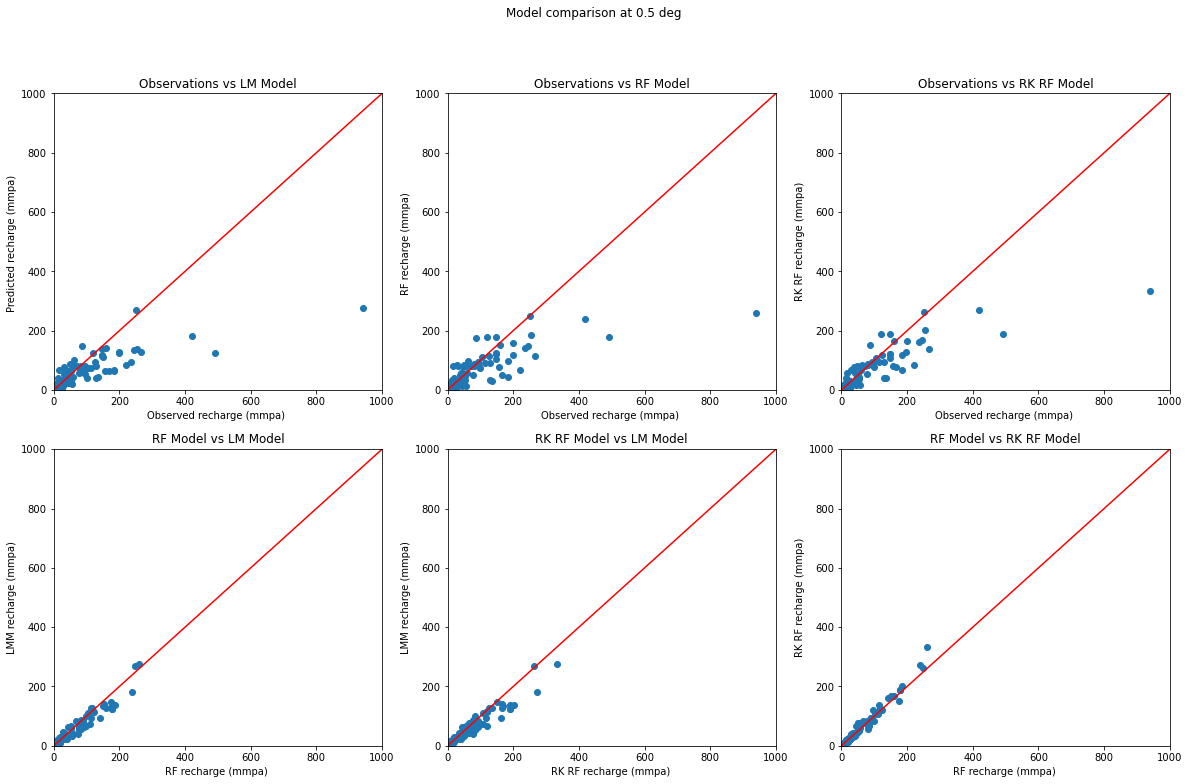

In [16]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
fig.suptitle('Model comparison at 0.5 deg')
axs = axs.flatten()
axs[0].plot(summary['Observations'], summary['LMM'],marker='o',linestyle='')
axs[0].plot(range(0,1000), range(0,1000), 'r')
axs[0].set_xlabel('Observed recharge (mmpa) ')
axs[0].set_ylabel('Predicted recharge (mmpa) ')
axs[0].set_xlim([0,1000])
axs[0].set_title('Observations vs LM Model')
axs[0].set_ylim([0,1000])

axs[1].plot(summary['Observations'], summary['RF'],marker='o',linestyle='')
axs[1].plot(range(0,1000), range(0,1000), 'r')
axs[1].set_xlabel('Observed recharge (mmpa) ')
axs[1].set_ylabel('RF recharge (mmpa) ')
axs[1].set_xlim([0,1000])
axs[1].set_title('Observations vs RF Model')
axs[1].set_ylim([0,1000])

axs[2].plot(summary['Observations'], summary['RK RF'],marker='o',linestyle='')
axs[2].plot(range(0,1000), range(0,1000), 'r')
axs[2].set_xlabel('Observed recharge (mmpa) ')
axs[2].set_ylabel('RK RF recharge (mmpa)')
axs[2].set_xlim([0,1000])
axs[2].set_title('Observations vs RK RF Model')
axs[2].set_ylim([0,1000])

axs[3].plot(summary['RF'], summary['LMM'],marker='o',linestyle='')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_xlabel('RF recharge (mmpa) ')
axs[3].set_ylabel('LMM recharge (mmpa)')
axs[3].set_xlim([0,1000])
axs[3].set_title('RF Model vs LM Model')
axs[3].set_ylim([0,1000])

axs[4].plot(summary['RK RF'], summary['LMM'],marker='o',linestyle='')
axs[4].plot(range(0,1000), range(0,1000), 'r')
axs[4].set_xlabel('RK RF recharge (mmpa) ')
axs[4].set_ylabel('LMM recharge (mmpa)')
axs[4].set_xlim([0,1000])
axs[4].set_title('RK RF Model vs LM Model')
axs[4].set_ylim([0,1000])

axs[5].plot(summary['RF'], summary['RK RF'],marker='o',linestyle='')
axs[5].plot(range(0,1000), range(0,1000), 'r')
axs[5].set_xlabel('RF recharge (mmpa) ')
axs[5].set_ylabel('RK RF recharge (mmpa)')
axs[5].set_xlim([0,1000])
axs[5].set_title('RF Model vs RK RF Model')
axs[5].set_ylim([0,1000])

In [17]:
# get residuals for regression kriging in R
# residuals_file = pd.read_csv('residuals.csv')
# residuals_file['Res_05'] = list(labels) - train_predictions
# residuals_file.to_csv('residuals.csv', index=False)